In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import keras

In [3]:
from keras import datasets

In [5]:
(x_train,y_train),(x_test,y_test)=datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
print('X_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)


Displying images with labels







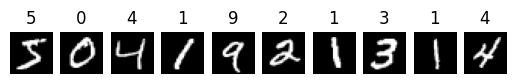

In [7]:
import matplotlib.pyplot as plt
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(x_train[i],cmap='gray')
  plt.title(y_train[i])
  plt.axis('off')


We want to create a neural network that works receives every pixel of the image as input so we need to reshape the data to have a signle array with 28 X 28 =784 pixels

In [8]:
x_train=x_train.reshape(-1,784)
x_test=x_test.reshape(-1,784)
print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)

x_train shape (60000, 784)
x_test shape (10000, 784)


We now normalize the pixel values to a range between 0 and 1 (instead of 0 to 255) we can use min-max normaizaion

In [9]:
x_train=x_train/255.0
x_test=x_test/255.0

We'll train a Siamese Network using positive and negative pairs of images. A positive pair consists of two images representing the same digit, while a negative pair consists of two images representing different digits.

In [11]:
import numpy as np


In [16]:
def generate_pairs(x,y):
  x_pairs=[]
  y_pairs=[]
  for i in range (len(x)):
    digit=y[i]
    positive_digit_index=np.random.choice(np.where(y==digit)[0])
    x_pairs.append([x[i],x[positive_digit_index]])
    y_pairs.append([0])

    negative_digit_index=np.random.choice(np.where(y!=digit)[0])
    x_pairs.append([x[i],x[negative_digit_index]])
    y_pairs.append([1])


  indicies = np.arange(len(x_pairs))
  np.random.shuffle(indicies)
  return np.array(x_pairs)[indicies], np.array(y_pairs)[indicies]

Let's generate the pairs for training and testing the model:

In [17]:
x_train_pairs, y_train_pairs = generate_pairs(x_train, y_train)
x_test_pairs, y_test_pairs = generate_pairs(x_test, y_test)

print("X_train_pairs shape:", x_train_pairs.shape)
print("X_test_pairs shape:",x_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
X_test_pairs shape: (20000, 2, 784)


Let's display some of these pairs to ensure they were generated correctly:

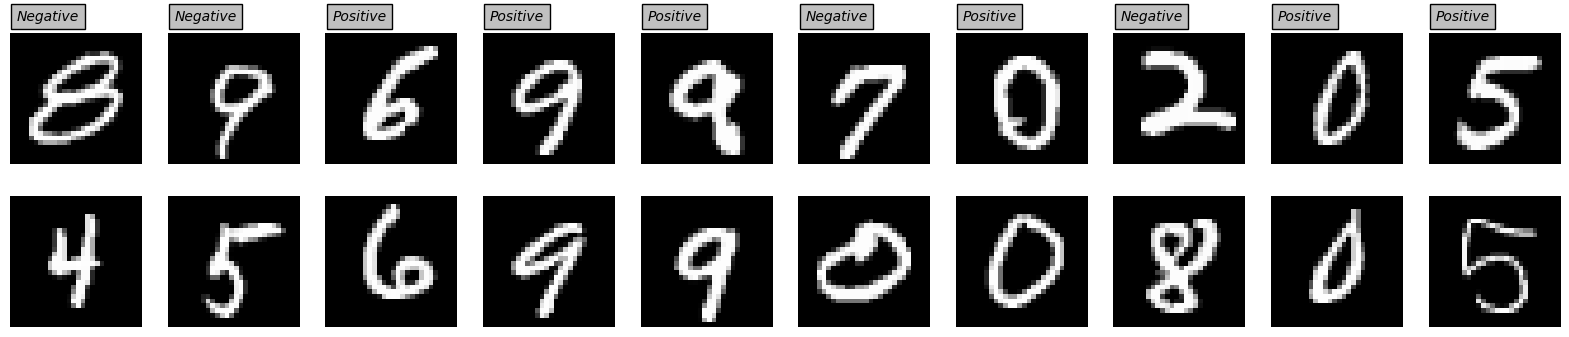

In [19]:
def display_pairs(X, y, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - X: An array containing the image pairs.
        - y: An array containing the corresponding label (0 if both
            pairs are the same, and 1 if both pairs are different.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()


display_pairs(x_train_pairs, y_train_pairs)

building the model


In [35]:
from keras import Input
import numpy as np
from keras.layers import Layer
from keras import backend as K


In [36]:
class EuclideanDistance(Layer):
  """
  Compute the euclidean distance (norm) of the output of
  the twin networks.
  """
  def __init__(self, **kwargs):
    super(EuclideanDistance, self).__init__(**kwargs)

  def call(self, twins):
    """
    Compute the euclidean distance (norm) of the output of
    the twin networks.
    """
    twin1_output, twin2_output = twins
    return K.sqrt(K.sum(K.square(twin1_output - twin2_output), axis=1, keepdims=True))


In [21]:
input1=Input(shape=(784,))
input2=Input(shape=(784,))


Then, we can build the body of the Siamese Network. This network will be responsible of generating the embeddings for each of the input images:

In [24]:
from keras.layers import Dense
from keras.models import Sequential

In [26]:
network= Sequential(
    [
        Input(shape=(784,)),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(128,activation=None),
    ]
)

Our network will have two branches, each one responsible for processing one of the images in the pair. We want to share the same weights between the branches, so we'll use the same network instance:

In [27]:
twin1=network(input1)
twin2=network(input2)


The output of the Siamese Network will be the distance between the embeddings of the two images. To do this, we can use a Lambda layer to calculate the Euclidean distance between the embeddings:

In [38]:
# Calculate the distance using the custom layer
distance = EuclideanDistance()([twin1, twin2])

In [39]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

In [41]:
from tensorflow.keras import backend as K

def contrastive_loss(y, d):
    """
    Compute the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping."
    """

    margin = 1
    y = K.cast(y, d.dtype)

    loss = (1 - y) / 2 * K.square(d) + y / 2 * K.square(K.maximum(0.0, margin - d))

    return loss

In [42]:
from keras.metrics import binary_accuracy

model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

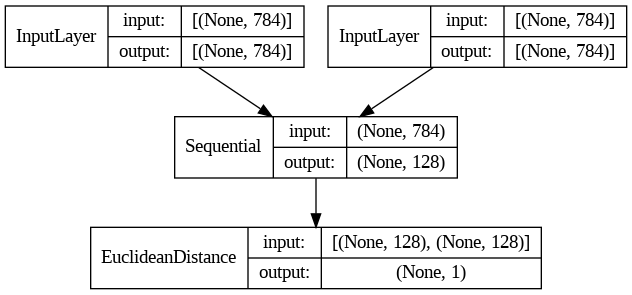

In [43]:
keras.utils.plot_model(
    model, to_file="model.png", show_shapes=True, show_layer_names=False
)

In [44]:
history = model.fit(
    x=[x_train_pairs[:, 0], x_train_pairs[:, 1]],
    y=y_train_pairs[:],
    validation_data=([x_test_pairs[:, 0], x_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32,
    epochs=5,
)

Epoch 1/5
3750/3750 [==============================] - 20s 4ms/step - loss: 0.0326 - binary_accuracy: 0.9329 - val_loss: 0.0234 - val_binary_accuracy: 0.9577
Epoch 2/5
3750/3750 [==============================] - 13s 4ms/step - loss: 0.0174 - binary_accuracy: 0.9748 - val_loss: 0.0203 - val_binary_accuracy: 0.9627
Epoch 3/5
3750/3750 [==============================] - 13s 4ms/step - loss: 0.0129 - binary_accuracy: 0.9846 - val_loss: 0.0178 - val_binary_accuracy: 0.9683
Epoch 4/5
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0102 - binary_accuracy: 0.9890 - val_loss: 0.0177 - val_binary_accuracy: 0.9676
Epoch 5/5
3750/3750 [==============================] - 16s 4ms/step - loss: 0.0086 - binary_accuracy: 0.9919 - val_loss: 0.0165 - val_binary_accuracy: 0.9696


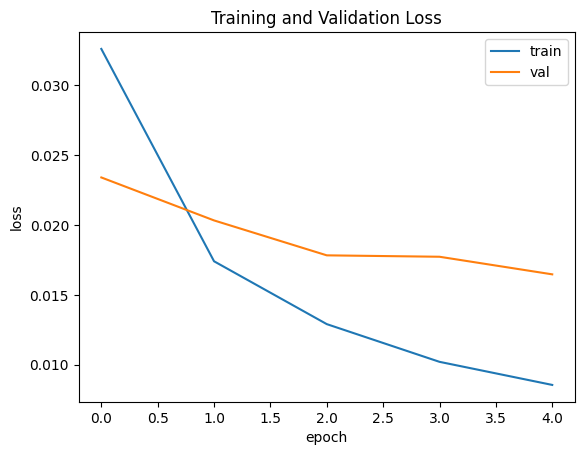

In [45]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

625/625 [==============================] - 1s 2ms/step


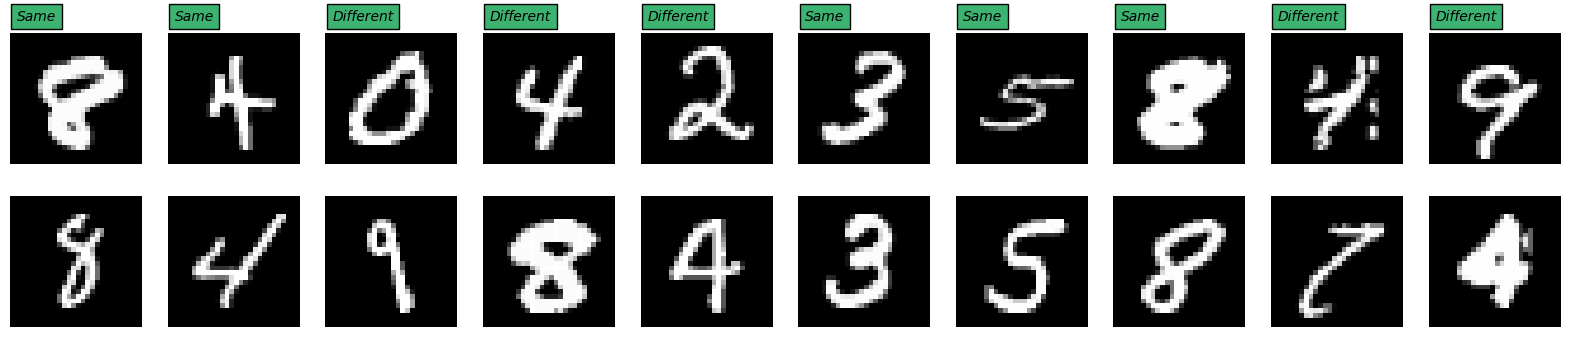

In [47]:
predictions = model.predict([x_test_pairs[:, 0], x_test_pairs[:, 1]]) >= 0.5
display_pairs(x_test_pairs, predictions, predictions == y_test_pairs)

In [48]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.97


These are the different layers of the model we trained

In [49]:
model.layers

We can reference the sequential model to generate embeddings for new images

In [50]:
embedding_model = model.layers[2]

Let's select two random images representing the digit 3, and one image representing the digit 7:

In [51]:
digits = np.where(y_test == 3)[0]
index1 = np.random.choice(digits)
index2 = np.random.choice(digits)
index3 = np.random.choice(np.where(y_test == 7)[0])

index1, index2, index3

(925, 2893, 3184)

We can generate the embeddings for these 3 images:

In [52]:
embedding1 = embedding_model.predict(x_test[index1].reshape(1, -1))
embedding2 = embedding_model.predict(x_test[index2].reshape(1, -1))
embedding3 = embedding_model.predict(x_test[index3].reshape(1, -1))

1/1 [==============================] - 0s 45ms/step


The distance between the embeddings of the two images representing the digit 3 should be really small (close to 0):

In [57]:
import numpy as np
from numpy.linalg import norm
norm(embedding1 - embedding2)

0.06702038

The distances between the embeddings of the images representing the digit 3 and the image representing the digit 7 should be large (close to 1):

In [58]:
norm(embedding1 - embedding3), norm(embedding2 - embedding3)

(1.0816343, 1.050107)